# Chron.jl coupled eruption/deposition age and age-depth model

This Jupyter notebook demonstrates the `Chron.jl` Julia package for integrated Bayesian eruption age and stratigraphic age-depth modelling, based in part on the work of [Keller, Schoene, and Samperton (2018)](https://doi.org/10.7185/geochemlet.1826), with age-depth modelling capabilities extended for use in [Schoene et al. (2019)](https://doi.org/10.1126/science.aau2422), [Deino et al. (2019a)](https://doi.org/10.1016/j.quascirev.2019.05.009) and [Deino et al. (2019b)](https://doi.org/10.1016/j.palaeo.2019.109258). For more information, see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl) and and [doi.org/10.17605/osf.io/TQX3F](https://doi.org/10.17605/osf.io/TQX3F)

<a href="https://mybinder.org/v2/gh/brenhinkeller/Chron.jl/main?filepath=examples%2FChron1.0Coupled.ipynb" target="_blank"><img src="https://static.mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    using Pkg
    Pkg.add("Chron")
    using Chron
end

using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
using Plots; gr(); default(fmt = :png)

***
## Enter sample information
First, let's enter some basic information about your samples. How many are there, what are the sample names (needs to be a valid filename, BTW), and what are the stratigraphic heights and uncertainties? Then, we'll enter the ages as .csv files.

In [2]:
nSamples = 5 # The number of samples you have data for
smpl = NewChronAgeData(nSamples)
smpl.Name      = ("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70",) # These have to match the names used above
smpl.Height   .= [     -52.0,      44.0,      54.0,      82.0,      93.0,]
smpl.Height_sigma  .= [  3.0,       1.0,       3.0,       3.0,       3.0,]
smpl.Age_Sidedness .= zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "MyData/" # Where are the data files? Must match where you put the csv files below.
smpl.inputSigmaLevel = 2 # i.e., are the data files 1-sigma or 2-sigma. Integer.

smpl.Age_Unit = "Ma" # Unit of measurement for ages and errors in the data files
smpl.Height_Unit = "cm"; # Unit of measurement for Height and Height_sigma

Note that smpl.Height *must* increase with increasing stratigraphic height -- i.e., stratigraphically younger samples must be more positive. For this reason, it is convenient to represent depths below surface as negative numbers.
***
Now let's see what's in our current directory (we'll use `;` to activate Julia's command-line shell mode, followed by a unix command, in this case `ls`

In [3]:
;ls

Chron1.0Coupled.ipynb
Chron1.0Coupled.jl
Chron1.0DistOnly.ipynb
Chron1.0DistOnly.jl
Chron1.0Radiocarbon.ipynb
Chron1.0Radiocarbon.jl
Chron1.0StratOnly.ipynb
Chron1.0StratOnly.jl
DenverUPbExampleData
EruptionDepositionAgeDemonstration.ipynb
EruptionDepositionAgeDemonstration.jl
MyData
ffsend


Equivalently, we can also run unix commands using the `run()` function

In [4]:
run(`ls`);

Chron1.0Coupled.ipynb
Chron1.0Coupled.jl
Chron1.0DistOnly.ipynb
Chron1.0DistOnly.jl
Chron1.0Radiocarbon.ipynb
Chron1.0Radiocarbon.jl
Chron1.0StratOnly.ipynb
Chron1.0StratOnly.jl
DenverUPbExampleData
EruptionDepositionAgeDemonstration.ipynb
EruptionDepositionAgeDemonstration.jl
MyData
ffsend


Now that we know how to access the command line, let's make a new folder for our example data. This can be called whatever you want, just make sure it matches `smpl.Path` above

In [5]:
;mkdir MyData/

mkdir: MyData/: File exists


Now, let's make some files and paste in csv data for each one. For now, I'm pasting in example data from Clyde et al. (2016), [10.1016/j.epsl.2016.07.041](https://doi.org/10.1016/j.epsl.2016.07.041)

In [6]:
# You can just paste your data in here, in the following two-column format.
# The first column is age and the second column is two-sigma analytical uncertainty.
# You should generally exclude all systematic uncertainties here.
data = [
66.12 0.14
66.115 0.048
66.11 0.1
66.11 0.17
66.096 0.056
66.088 0.081
66.085 0.076
66.073 0.084
66.07 0.11
66.055 0.043
66.05 0.16
65.97 0.12
]

# Now, let's write this data to a file, delimited by commas (',')
# In this example the filename is KJ08-157.csv, in the folder called MyData
writedlm("MyData/KJ08-157.csv", data, ',')

In [7]:
data = [
66.24 0.25
66.232 0.046
66.112 0.085
66.09 0.1
66.04 0.18
66.03 0.12
66.016 0.08
66.003 0.038
65.982 0.071
65.98 0.19
65.977 0.042
65.975 0.066
65.971 0.082
65.963 0.074
65.92 0.12
65.916 0.088
]
writedlm("MyData/KJ04-75.csv",data,',')

In [8]:
data = [
66.13 0.15
66.066 0.052
65.999 0.045
65.989 0.057
65.98 0.11
65.961 0.057
65.957 0.091
65.951 0.066
65.95 0.11
65.929 0.059
]
writedlm("MyData/KJ09-66.csv",data,',')

In [9]:
data = [
66.11 0.2
66.003 0.063
66.003 0.058
65.98 0.06
65.976 0.089
65.973 0.084
65.97 0.15
65.963 0.055
65.959 0.049
65.94 0.18
65.928 0.066
65.92 0.057
65.91 0.14
]
writedlm("MyData/KJ04-72.csv",data,',')

In [10]:
data = [
66.22 0.27
66.06 0.11
65.933 0.066
65.918 0.087
65.92 0.34
65.916 0.067
65.91 0.18
65.892 0.09
65.89 0.063
65.89 0.15
65.88 0.2
65.812 0.069
65.76 0.15
]
writedlm("MyData/KJ04-70.csv",data,',')

Alternatively, you could download .csv files that you have posted somewhere online using the Julia `download()` function, or using the unix command `curl` throught the command-line interface

For each sample in `smpl.Name`, we must have a `.csv` file in `smpl.Path` which contains each individual mineral age and uncertainty.

***
## Configure and run eruption/deposition age model
To learn more about the eruption/deposition age estimation model, see also [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) and the [BayeZirChron demo notebook](http://brenh.in/BayeZirChron). It is important to note that this model (like most if not all others) has no knowledge of open-system behaviour, so *e.g.*, Pb-loss will lead to erroneous results.

#### Boostrap relative pre-eruptive (or pre-depositional) mineral age distribution

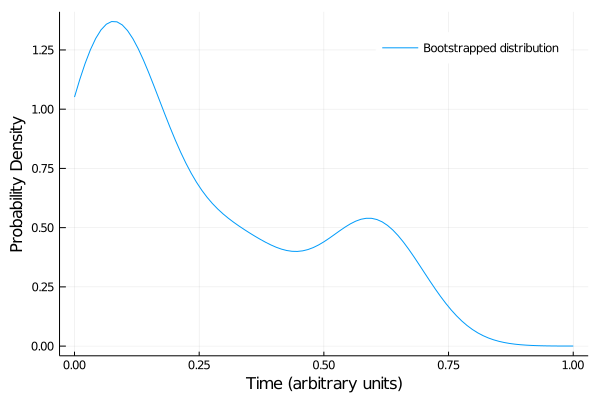

In [11]:
# Bootstrap a KDE of the pre-eruptive (or pre-deposition) zircon distribution
# shape from individual sample datafiles using a KDE of stacked sample data
BootstrappedDistribution = BootstrapCrystDistributionKDE(smpl)
h = plot(range(0,1,length=length(BootstrappedDistribution)), BootstrappedDistribution,
    label="Bootstrapped distribution", xlabel="Time (arbitrary units)", ylabel="Probability Density", 
    fg_color_legend=:white)
savefig(h, joinpath(smpl.Path,"BootstrappedDistribution.pdf"))
display(h)

#### Run eruption/deposition age model

In [12]:
# Number of steps to run in distribution MCMC
distSteps = 10^6
distBurnin = floor(Int,distSteps/100)

# Choose the form of the prior distribution to use
# Some pre-defined possiblilities include UniformDisribution,
# TriangularDistribution, and MeltsVolcanicZirconDistribution
# or you can define your own as with BootstrappedDistribution above
dist = BootstrappedDistribution

# Run MCMC to estimate saturation and eruption/deposition age distributions
smpl = tMinDistMetropolis(smpl,distSteps,distBurnin,dist)
results = vcat(["Sample" "Age" "2.5% CI" "97.5% CI" "sigma"], hcat(collect(smpl.Name),smpl.Age,smpl.Age_025CI,smpl.Age_975CI,smpl.Age_sigma))
writedlm(smpl.Path*"results.csv", results, ',');

Estimating eruption/deposition age distributions...
1: KJ08-157
2: KJ04-75
3: KJ09-66
4: KJ04-72
5: KJ04-70


In [13]:
# Let's see what that did
run(`ls $(smpl.Path)`); sleep(0.5)
results = readdlm(smpl.Path*"results.csv",',')

BootstrappedDistribution.pdf
KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_distribution.svg
KJ04-70_rankorder.pdf
KJ04-70_rankorder.svg
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_distribution.svg
KJ04-72_rankorder.pdf
KJ04-72_rankorder.svg
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_distribution.svg
KJ04-75_rankorder.pdf
KJ04-75_rankorder.svg
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_distribution.svg
KJ08-157_rankorder.pdf
KJ08-157_rankorder.svg
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_distribution.svg
KJ09-66_rankorder.pdf
KJ09-66_rankorder.svg
results.csv


6×5 Array{Any,2}:
 "Sample"      "Age"    "2.5% CI"    "97.5% CI"   "sigma"
 "KJ08-157"  66.0703  66.0343      66.0935       0.0149756
 "KJ04-75"   65.9318  65.886       65.9707       0.0218798
 "KJ09-66"   65.9368  65.8915      65.9779       0.0219181
 "KJ04-72"   65.9551  65.9219      65.9766       0.0138594
 "KJ04-70"   65.8307  65.7535      65.8949       0.0365122

To see what one of these plots looks like, try pasting this into a markdown cell like the one below
```
<img src="MyData/KJ04-75_rankorder.svg" align="left" width="600"/>
```

<img src="MyData/KJ04-75_rankorder.svg" align="left" width="600"/>

For each sample, the eruption/deposition age distribution is inherently asymmetric, because of the one-sided relationship between mineral closure and eruption/deposition. For example (KJ04-70):

<img src="MyData/KJ04-70_distribution.svg" align="left" width="600"/>

(if no figure appears, double-click to enter this markdown cell and re-evaluate (`shift`-`enter`) after running the model above

Consequently, rather than simply taking a mean and standard deviation of the stationary distribtuion of the Markov Chain, the histogram of the stationary distribution is fit to an empirical distribution function of the form 

$
\begin{align}
f(x) = a * \exp\left[d e \frac{x - b}{c}\left(\frac{1}{2} - \frac{\arctan\left(\frac{x - b}{c}\right)}{\pi}\right)  - \frac{d}{e}\frac{x - b}{c}\left(\frac{1}{2} + \frac{\arctan\left(\frac{x - b}{c}\right)}{\pi}\right)\right]
\end{align}
$

where 

$
\begin{align}
\{a,c,d,e\} \geq 0
\end{align}
$

*i.e.*, an asymmetric exponential function with two log-linear segments joined with an arctangent sigmoid. After fitting, the five parameters $a$ - $e$ are stored in `smpl.params` and passed to the stratigraphic model

***
## Configure and run stratigraphic model

To run the stratigraphic MCMC model, we call the `StratMetropolisDist` function. If you want to skip the first step and simply input run the stratigraphic model with Gaussian mean age and standard deviation for some number of stratigraphic horizons, then you can set `smpl.Age` and `smpl.Age_sigma` directly, but then you'll need to call `StratMetropolis` instead of `StratMetropolisDist`

Generating stratigraphic age-depth model...
Burn-in: 5840000 steps


Burn-in...100%|█████████████████████████████████████████| Time: 0:00:02


Collecting...100%|██████████████████████████████████████| Time: 0:00:03


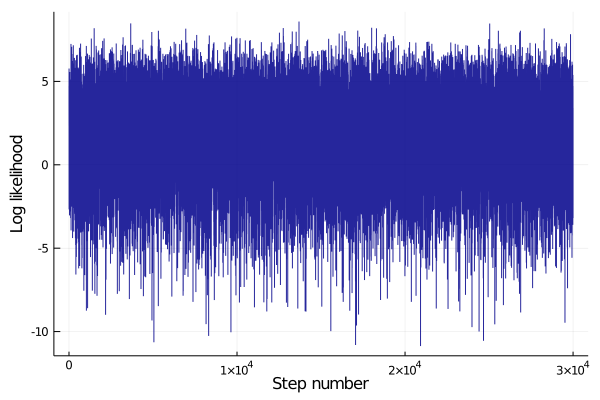

In [14]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If you in doubt, you can probably leave these parameters as-is
config.resolution = 1.0 # Same units as sample height. Smaller is slower!
config.bounding = 0.5 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 20000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolisDist(smpl, config); sleep(0.5)

# Plot the log likelihood to make sure we're converged (n.b burnin isn't recorded)
plot(lldist,xlabel="Step number",ylabel="Log likelihood",label="",line=(0.85,:darkblue))

The most important output of this process is `agedist`, which contains the full stationary distribution of the age-depth model. We can save it to a file, but if this notebook is running remotely, you may have trouble getting it out of here (see section **Getting your data out**)!

In [15]:
writedlm(smpl.Path*"agedist.csv", agedist, ',') # Stationary distribution of the age-depth model
writedlm(smpl.Path*"height.csv", mdl.Height, ',') # Stratigraphic heights corresponding to each row of agedist
writedlm(smpl.Path*"lldist.csv", lldist, ',') # Log likelihood distribution (to check for stationarity)

***
## Plot results

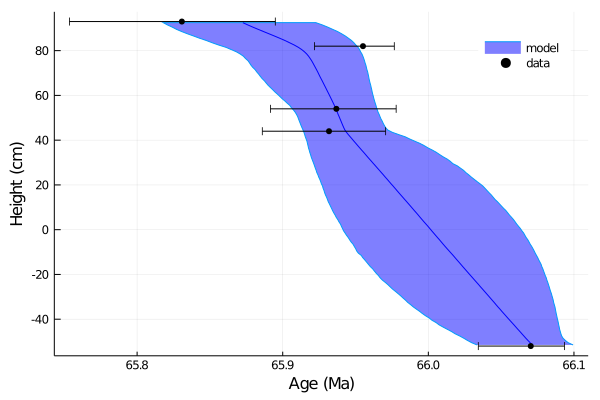

In [16]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(round(Int,minimum(mdl.Height)),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white) # Center line
t = smpl.Age_Sidedness .== 0 # Two-sided constraints (plot in black)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],smpl.Age_975CI[t]-smpl.Age[t]),label="data",seriestype=:scatter,color=:black)
t = smpl.Age_Sidedness .== 1 # Minimum ages (plot in cyan)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],zeros(count(t))),label="",seriestype=:scatter,color=:cyan,msc=:cyan)
any(t) && zip(smpl.Age[t], smpl.Age[t].+nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:cyan)
t = smpl.Age_Sidedness .== -1 # Maximum ages (plot in orange)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(zeros(count(t)),smpl.Age_975CI[t]-smpl.Age[t]),label="",seriestype=:scatter,color=:orange,msc=:orange)
any(t) && zip(smpl.Age[t], smpl.Age[t].-nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:orange)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")
savefig(hdl,smpl.Path*"AgeDepthModel.svg")
savefig(hdl,smpl.Path*"AgeDepthModel.pdf")
display(hdl)

Interpolated age: 66.00167048497062 +0.06206226408366433/-0.06024663189923274 Ma

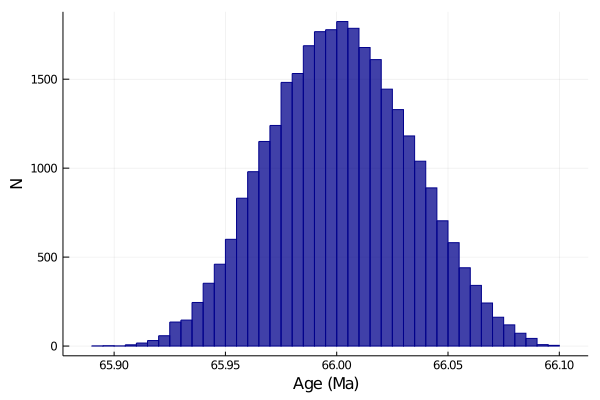

In [17]:
# Interpolate results at a given height
height = 0

interpolated_age = linterp1s(mdl.Height,mdl.Age,height)
interpolated_age_min = linterp1s(mdl.Height,mdl.Age_025CI,height)
interpolated_age_max = linterp1s(mdl.Height,mdl.Age_975CI,height)
print("Interpolated age: $interpolated_age +$(interpolated_age_max-interpolated_age)/-$(interpolated_age-interpolated_age_min) Ma")

# We can also interpolate the full distribution:
interpolated_distribution = Array{Float64}(undef,size(agedist,2))
for i=1:size(agedist,2)
    interpolated_distribution[i] = linterp1s(mdl.Height,agedist[:,i],height)
end
histogram(interpolated_distribution, xlabel="Age ($(smpl.Age_Unit))", ylabel="N", label="", fill=(0.75,:darkblue), linecolor=:darkblue)

There are other things we can plot as well, such as deposition rate:

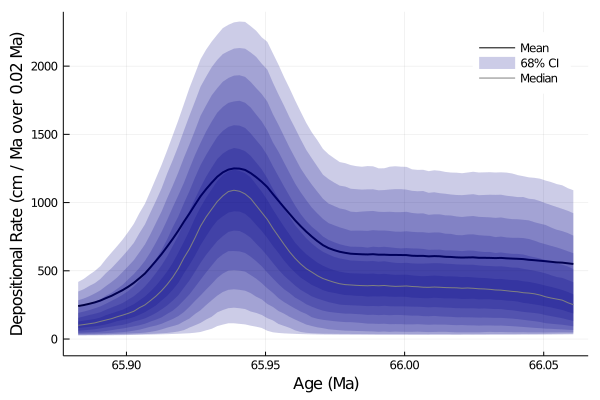

  0.619619 seconds (1.63 M allocations: 231.080 MiB, 11.73% gc time)


In [18]:
# Set bin width and spacing
binwidth = round(nanrange(mdl.Age)/10,sigdigits=1) # Can also set manually, commented out below
# binwidth = 0.01 # Same units as smpl.Age
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] .= abs.(heights[1:end-spacing] .- heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = nanpctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = nanpctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = nanpctile(dhdt_dist,20,dim=2)
dhdt_80p = nanpctile(dhdt_dist,80,dim=2)
dhdt_25p = nanpctile(dhdt_dist,25,dim=2)
dhdt_75p = nanpctile(dhdt_dist,75,dim=2)
dhdt_30p = nanpctile(dhdt_dist,30,dim=2)
dhdt_70p = nanpctile(dhdt_dist,70,dim=2)
dhdt_35p = nanpctile(dhdt_dist,35,dim=2)
dhdt_65p = nanpctile(dhdt_dist,65,dim=2)
dhdt_40p = nanpctile(dhdt_dist,40,dim=2)
dhdt_60p = nanpctile(dhdt_dist,60,dim=2)
dhdt_45p = nanpctile(dhdt_dist,45,dim=2)
dhdt_55p = nanpctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Depositional Rate ($(smpl.Height_Unit) / $(smpl.Age_Unit) over $binwidth $(smpl.Age_Unit))", fg_color_legend=:white)
savefig(hdl,smpl.Path*"DepositionRateModelCI.svg")
savefig(hdl,smpl.Path*"DepositionRateModelCI.pdf")
display(hdl)

***
## Getting your data out
As before, we can use the unix command `ls` to see all the files we have written. Actually getting them out of here may be harder though.

In [19]:
;ls MyData

AgeDepthModel.pdf
AgeDepthModel.svg
BootstrappedDistribution.pdf
DepositionRateModelCI.pdf
DepositionRateModelCI.svg
KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_distribution.svg
KJ04-70_rankorder.pdf
KJ04-70_rankorder.svg
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_distribution.svg
KJ04-72_rankorder.pdf
KJ04-72_rankorder.svg
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_distribution.svg
KJ04-75_rankorder.pdf
KJ04-75_rankorder.svg
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_distribution.svg
KJ08-157_rankorder.pdf
KJ08-157_rankorder.svg
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_distribution.svg
KJ09-66_rankorder.pdf
KJ09-66_rankorder.svg
agedist.csv
height.csv
lldist.csv
results.csv


We could use the trick we learned before to view the SVG files in markdown cells, which you should then be able to right click and download as real vector graphics. e.g. pasting something like
```
<img src="AgeDepthModel.svg" align="left" width="600"/>
```
in a markdown cell such as this one

Meanwhile, for the csv files we could try something like `; cat agedist.csv`, but agedist is probably too big to print. Let's try using ffsend instead, which should give you a download link. In fact, while we're at it, we might as well archive and zip the entire directory!

In [20]:
# Make gzipped tar archive of the the whole MyData directory
run(`tar -zcf archive.tar.gz ./MyData`);

In [21]:
# Download prebuilt ffsend linux binary
download("https://github.com/timvisee/ffsend/releases/download/v0.2.65/ffsend-v0.2.65-linux-x64-static", "ffsend")

# Make ffsend executable
run(`chmod +x ffsend`);

In [22]:
; ./ffsend upload archive.tar.gz

/bin/bash: ./ffsend: cannot execute binary file


You could alternatively use the ffsend command in this way to transfer individual files, for instance `; ./ffsend upload MyData/agedist.csv`

Keep in mind that any changes you make to this online notebook won't persist after you close the tab (or after it times out) even if you save your changes! You have to either copy-paste or `file`>`Download as` a copy.
***
## Stratigraphic model including hiatuses
We can also deal with discrete hiatuses in the stratigraphic section if we know where they are and about how long they lasted. We need some different models and methods though. In particular, in addition to the `ChronAgeData` struct, we also need a `HiatusData` struct now, and will have a new output `hiatusdist` as well. This section is commented out, but you can uncomment, edit, and run if you have hiata of know duration in your section

Generating stratigraphic age-depth model...
Burn-in: 5840000 steps


Burn-in...100%|█████████████████████████████████████████| Time: 0:00:04


Collecting...100%|██████████████████████████████████████| Time: 0:00:07


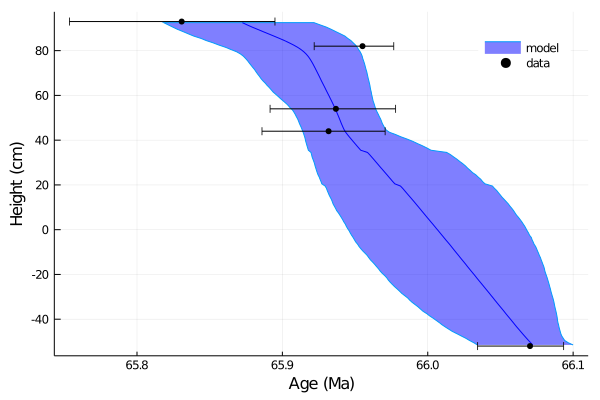

In [23]:
# Data about hiatuses
nHiatuses = 2 # The number of hiatuses you have data for
hiatus = NewHiatusData(nHiatuses) # Struct to hold data
hiatus.Height         = [20.0, 35.0 ]
hiatus.Height_sigma   = [ 0.0,  0.0 ]
hiatus.Duration       = [ 0.2,  0.43]
hiatus.Duration_sigma = [ 0.05, 0.07]

# Run the model. Note the new `hiatus` argument and `hiatusdist` result
(mdl, agedist, hiatusdist, lldist) = StratMetropolisDist(smpl, hiatus, config); sleep(0.5)

# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white)
plot!(hdl, smpl.Age, smpl.Height, xerror=(smpl.Age-smpl.Age_025CI,smpl.Age_975CI-smpl.Age),label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")

***
[![DOI](https://github.com/brenhinkeller/Chron.jl/raw/main/readme_figures/osf_io_TQX3F.svg?sanitize=true)](https://doi.org/10.17605/osf.io/TQX3F) 